In [1]:
import numpy as np
import pandas as pd
import nltk
import spacy
import tensorflow as tf
import string
import re
import random
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import word2vec, FastText
import gensim.downloader
from sklearn.decomposition import PCA

In [2]:
df=pd.read_csv('resume_entities.csv')

In [3]:
df

,sentence,token,tag
0,Sentence: 1,Abhishek,B-Name
1,Sentence: 1,Jha,I-Name
2,Sentence: 1,Application,B-Designation
3,Sentence: 1,Development,I-Designation
4,Sentence: 1,Associate,I-Designation
...,...,...,...
60746,Sentence: 220,false,O
60747,Sentence: 220,"positive,",O
60748,Sentence: 220,fine,O
60749,Sentence: 220,tuning,O


In [4]:
print('Number of sentences are '+str(df['sentence'].nunique()))
print('Number of Vocabs are '+str(df['token'].nunique()))

Number of sentences are 218
Number of Vocabs are 18919


In [5]:
import xml.etree.ElementTree as ET
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
import gensim.downloader as api
from tensorflow.keras.layers import Embedding

tf.random.set_seed(123)

In [6]:
df['token']=df['token'].str.lower()

In [7]:
sentence_all = [(list(zip(group['token'], group['tag']))) for _, group in df.groupby('sentence')]

In [8]:
# Calculate the value counts for the "sentence" column
sentence_counts = df['sentence'].value_counts()

# Find the maximum value of the value counts
max_count = sentence_counts.max()
min_count = sentence_counts.min()

# Print the maximum value
print("Maximum value of sentence counts:", max_count)
print("Minimum value of sentence counts:", min_count)

Maximum value of sentence counts: 1149
Minimum value of sentence counts: 24


In [9]:
MAX_LEN = 1150
EMBEDDING = 342

In [10]:
words = list(set(df['token'].values))
tags = list(set(df["tag"].values))

In [11]:
#Creating word to index and tag to index
import sklearn

# Vocabulary Key:word -> Value:token_index
# The first 2 entries are reserved for PAD and UNK
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1 # Unknown words
word2idx["PAD"] = 0 # Padding

# Vocabulary Key:token_index -> Value:word
idx2word = {i: w for w, i in word2idx.items()}

# Vocabulary Key:Label/Tag -> Value:tag_index
# The first entry is reserved for PAD
tag2idx = {t: i+1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0

# Vocabulary Key:tag_index -> Value:Label/Tag
idx2tag = {i: w for w, i in tag2idx.items()}

# word embeddings

# glove embeddings

In [12]:
word2vec = {}  # Define the 'vocab' dictionary before the loop
with open('glove.840B.300d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        if len(values) < 2:
            continue
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
            word2vec[word] = coefs
        except ValueError:
            continue

In [13]:
# Embedding the word matrix, we will add this
hits = 0
misses = 0
# word2vec = api.load("word2vec-google-news-300")
embedding_dim = 300

# Prepare embedding matrix
embedding_matrix = np.zeros((len(word2idx), embedding_dim))
for word, i in zip(word2idx.keys(),word2idx.values()):
    embedding_vector = None
    try:
      embedding_vector = word2vec[word]
    except Exception :
      pass

    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 8028 words (7521 misses)


# pos and ner embeddings

In [14]:
nlp = spacy.load("en_core_web_sm")

In [15]:
text_list = [' '.join(map(str, tokens)) for tokens in sentence_all]

In [16]:
pos_dict = {token: 'UNK' for token in words}
ner_dict = {token: ('UNK', 'UNK') for token in words}

pos=0
ner=0

for text in text_list:
    doc=nlp(text)
    for token in doc:
        if token.text in words and pos_dict[token.text]=='UNK':
            pos_dict[token.text]=token.pos_
            pos=pos+1
        if token.text in words and ner_dict[token.text]==('UNK','UNK'):
            ner_dict[token.text]=(token.ent_iob_, token.ent_type_)
            ner=ner+1

In [17]:
print(len(pos_dict))
print(len(ner_dict))
print(len(words))

15547
15547
15547


In [18]:
df2=df

In [19]:
df2['pos_tag'] = 'UNK'
df2['ner_BIO'] = 'UNK'
df2['ner_tag'] = 'UNK'

for index, row in df.iterrows():
    token= df2['token'][index]
    df2['pos_tag'][index]= pos_dict[token]
    df2['ner_BIO'][index]= ner_dict[token][0]
    df2['ner_tag'][index]= ner_dict[token][1]

In [21]:
pos_tags = list(set(df2['pos_tag'].values))
ner_BIO_tags = list(set(df2["ner_BIO"].values))
ner_tags = list(set(df2["ner_tag"].values))

In [22]:
pos_tag2idx = {t: i+1 for i, t in enumerate(pos_tags)}
pos_tag2idx["PAD"] = 0

# Vocabulary Key:tag_index -> Value:Label/Tag
idx2pos_tag = {i: w for w, i in pos_tag2idx.items()}


ner_tag2idx = {t: i+1 for i, t in enumerate(ner_tags)}
ner_tag2idx["PAD"] = 0

# Vocabulary Key:tag_index -> Value:Label/Tag
idx2ner_tag = {i: w for w, i in ner_tag2idx.items()}


ner_BIO_tag2idx = {t: i+1 for i, t in enumerate(ner_BIO_tags)}
ner_BIO_tag2idx["PAD"] = 0

# Vocabulary Key:tag_index -> Value:Label/Tag
idx2ner_BIO_tag = {i: w for w, i in ner_BIO_tag2idx.items()}

In [23]:
print(len(word2idx))
print(len(tag2idx))
print(len(pos_tag2idx))
print(len(ner_tag2idx))
print(len(ner_BIO_tag2idx))

15549
22
19
16
5


# one hot encoding

In [24]:
one_hot_encoded_pos = pd.get_dummies(df2['pos_tag'], prefix='pos_tag')
# df = pd.concat([df, one_hot_encoded_pos], axis=1)

In [25]:
one_hot_encoded_pos

,pos_tag_ADJ,pos_tag_ADP,pos_tag_ADV,pos_tag_AUX,pos_tag_CCONJ,pos_tag_DET,pos_tag_INTJ,pos_tag_NOUN,pos_tag_NUM,pos_tag_PART,pos_tag_PRON,pos_tag_PROPN,pos_tag_PUNCT,pos_tag_SCONJ,pos_tag_SYM,pos_tag_UNK,pos_tag_VERB,pos_tag_X
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60746,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
60747,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
60748,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
60749,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [26]:
df2['One_Hot_Encodings_pos'] = one_hot_encoded_pos.apply(lambda row: row.to_list(), axis=1)

In [27]:
one_hot_encoded_ner_BIO = pd.get_dummies(df2['ner_BIO'], prefix='ner_BIO')

In [28]:
one_hot_encoded_ner_BIO

,ner_BIO_B,ner_BIO_I,ner_BIO_O,ner_BIO_UNK
0,0,0,1,0
1,0,0,1,0
2,0,0,1,0
3,0,0,1,0
4,0,0,1,0
...,...,...,...,...
60746,0,0,1,0
60747,0,0,0,1
60748,0,0,1,0
60749,0,0,1,0


In [29]:
df2['One_Hot_Encodings_ner_BIO'] = one_hot_encoded_ner_BIO.apply(lambda row: row.to_list(), axis=1)

In [30]:
one_hot_encoded_ner_tag = pd.get_dummies(df2['ner_tag'], prefix='ner_tag')

In [31]:
one_hot_encoded_ner_tag

,ner_tag_,ner_tag_CARDINAL,ner_tag_DATE,ner_tag_GPE,ner_tag_LANGUAGE,ner_tag_LOC,ner_tag_NORP,ner_tag_ORDINAL,ner_tag_ORG,ner_tag_PERCENT,ner_tag_PERSON,ner_tag_PRODUCT,ner_tag_TIME,ner_tag_UNK,ner_tag_WORK_OF_ART
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60746,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
60747,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
60748,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
60749,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [32]:
df2['One_Hot_Encodings_ner_tag'] = one_hot_encoded_ner_tag.apply(lambda row: row.to_list(), axis=1)

In [33]:
df2['char embeddings'] = df2.apply(lambda row: row['One_Hot_Encodings_pos'] + row['One_Hot_Encodings_ner_BIO'] + row['One_Hot_Encodings_ner_tag'], axis=1)

In [34]:
len(df2['char embeddings'][0])

37

In [36]:
len(df2['One_Hot_Encodings_pos'][0])

18

In [37]:
len(df2['One_Hot_Encodings_ner_BIO'][0])

4

In [38]:
len(df2['One_Hot_Encodings_ner_tag'][0])

15

In [35]:
df

,sentence,token,tag,pos_tag,ner_BIO,ner_tag,One_Hot_Encodings_pos,One_Hot_Encodings_ner_BIO,One_Hot_Encodings_ner_tag,char embeddings
0,Sentence: 1,abhishek,B-Name,X,O,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Sentence: 1,jha,I-Name,X,O,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Sentence: 1,application,B-Designation,NOUN,O,,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
3,Sentence: 1,development,I-Designation,NOUN,O,,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
4,Sentence: 1,associate,I-Designation,VERB,O,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...
60746,Sentence: 220,false,O,ADJ,O,,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
60747,Sentence: 220,"positive,",O,UNK,UNK,UNK,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
60748,Sentence: 220,fine,O,ADJ,O,,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
60749,Sentence: 220,tuning,O,VERB,O,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [40]:
char_embeddings_dict={}
for index, row in df.iterrows():
    char_embeddings_dict[df2['token'][index]]= df2['char embeddings'][index]
    
char_embeddings_dict['UNK']=np.zeros(37)
char_embeddings_dict['PAD']=np.zeros(37)

In [41]:
len(char_embeddings_dict)

15549

In [42]:
embedding_matrix.shape

(15549, 300)

In [43]:
len(word2idx)

15549

In [44]:
char_embeddings=np.zeros((len(word2idx), 37))
for word, i in zip(word2idx.keys(),word2idx.values()):
    char_embeddings[i]=char_embeddings_dict[word]

In [45]:
char_embeddings.shape

(15549, 37)

In [46]:
# Prepare embedding matrix
final_embedding_matrix = np.zeros((len(word2idx), 337))
i=0
for word, i in zip(word2idx.keys(),word2idx.values()):
    final_embedding_matrix[i]= np.concatenate((embedding_matrix[i] , char_embeddings[i]))

In [47]:
final_embedding_matrix.shape

(15549, 337)

# bilstm-CRF model

In [48]:
#Tagging word to index and tag to index

#from keras.preprocessing.sequence import pad_sequences
#from keras_preprocessing.sequence import pad_sequences
from keras_preprocessing.sequence import pad_sequences

# Convert each sentence from list of Token to list of word_index
X = [[word2idx[w[0]] for w in s] for s in sentence_all]

# Padding each sentence to have the same lenght
X = pad_sequences(maxlen=MAX_LEN, sequences=X, padding="post", value=word2idx["PAD"])

# Convert Tag/Label to tag_index
y = [[tag2idx[w[1]] for w in s] for s in sentence_all]

# Padding each sentence to have the same lenght
y = pad_sequences(maxlen=MAX_LEN, sequences=y, padding="post", value=tag2idx["PAD"])
from keras.utils import to_categorical

# One-Hot encode
y = [to_categorical(i, num_classes=len(tags)+1) for i in y]  # n_tags+1(PAD)
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)
X_tr.shape, X_te.shape, np.array(y_tr).shape, np.array(y_te).shape


print('Raw Sample:\n ', ' '.join([w[0] for w in sentence_all[1]]))
print('\n ' )
print('Raw Label:\n ', ' '.join([w[1] for w in sentence_all[1]]))
print('\n ' )
print('After processing, sample:\n', X[0])
print('\n ' )
print('After processing, labels:\n', y[0])

Raw Sample:
  ashok kunam team lead - microsoft email me on indeed: indeed.com/r/ashok-kunam/7aac8767aacf10a0 • software engineering professional with over 2.5 years of experience in development, enhancement, integration, implementation and maintenance software applications using oracle served some the major clients such as microsoft, cisco, eloqua, italent knowledge operating systems (os) coding techniques, internet protocol (ip), interfaces hardware subsystems, reading schematics data sheets for components expertise java, j2ee, hibernate, spring, php, nifi, angular js, javascript, jquery, rest web services, jive, lithium successfully developed cloud based connectors services jive custom tiles & plugins proficient end-to-end various projects; including designing, coding, debugging, analyzing logs proven skills understanding business requirements translating them into technical specifications possess interpersonal, analytical negotiation proven track record utilizing a process-oriented

In [49]:
X_tr.shape, X_te.shape, np.array(y_tr).shape, np.array(y_te).shape

((196, 1150), (22, 1150), (196, 1150, 22), (22, 1150, 22))

In [50]:
y_tr = np.array(y_tr)
y_te = np.array(y_te)

In [51]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow_addons.utils.types import FloatTensorLike, TensorLike
from tensorflow_addons.layers import CRF
from tensorflow_addons.losses import SigmoidFocalCrossEntropy
from tensorflow_addons.optimizers import AdamW



def build_model(max_len = MAX_LEN, input_dim = len(word2idx),embedding_dim = 337):
  # Model definition
  input = Input(shape=(max_len,))

  # Get embeddings
  embeddings = Embedding(
      input_dim,
      embedding_dim,
      weights=[final_embedding_matrix],
    input_length=max_len,
       mask_zero=True,
    trainable=True,
      name = 'embedding_layer'
  )(input)

  # variational biLSTM
  output_sequences = Bidirectional(LSTM(units=50, return_sequences=True))(embeddings)
  output_sequences = Bidirectional(LSTM(units=100, return_sequences=True))(output_sequences)
  # Stacking
  output_sequences = Bidirectional(LSTM(units=50, return_sequences=True))(output_sequences)

  # Adding more non-linearity
  dense_out = TimeDistributed(Dense(25, activation="relu"))(output_sequences)

  # CRF layer
  mask = Input(shape=(max_len,), dtype=tf.bool)
  crf = CRF(22, name='crf')
  predicted_sequence, potentials, sequence_length, crf_kernel = crf(dense_out)

  model = Model(input, potentials)
  model.compile(
      optimizer=AdamW(weight_decay=0.001),
      loss= SigmoidFocalCrossEntropy()) # Sigmoid focal cross entropy loss

  return model

model = build_model()

# Checkpointing
save_model = tf.keras.callbacks.ModelCheckpoint(filepath='ner_crf.h5',
  monitor='val_loss',
  save_weights_only=True,
  save_best_only=True,
  verbose=1
)

# Early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=10)

callbacks = [save_model, es]

model.summary()

C:\Users\punna\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1150)]            0         
                                                                 
 embedding_layer (Embedding  (None, 1150, 337)         5240013   
 )                                                               
                                                                 
 bidirectional (Bidirection  (None, 1150, 100)         155200    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 1150, 200)         160800    
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, 1150, 100)         100400    
 onal)                                                       

In [53]:
history = model.fit(
  X_tr,
  y_tr,
  batch_size=64,
  epochs=20,
  validation_data=(X_te, y_te),
  callbacks=callbacks,
  shuffle=True
)

Epoch 1/20
4/4 [==============================] - ETA: 0s - loss: 0.6210  
Epoch 1: val_loss did not improve from 0.59507
4/4 [==============================] - 1093s 249s/step - loss: 0.6210 - val_loss: 0.5953
Epoch 2/20
4/4 [==============================] - ETA: 0s - loss: 0.6031  
Epoch 2: val_loss improved from 0.59507 to 0.52717, saving model to ner_crf.h5
4/4 [==============================] - 1065s 242s/step - loss: 0.6031 - val_loss: 0.5272
Epoch 3/20
4/4 [==============================] - ETA: 0s - loss: 0.5415  
Epoch 3: val_loss improved from 0.52717 to 0.48921, saving model to ner_crf.h5
4/4 [==============================] - 1096s 250s/step - loss: 0.5415 - val_loss: 0.4892
Epoch 4/20
4/4 [==============================] - ETA: 0s - loss: 0.5001  
Epoch 4: val_loss improved from 0.48921 to 0.44774, saving model to ner_crf.h5
4/4 [==============================] - 1315s 310s/step - loss: 0.5001 - val_loss: 0.4477
Epoch 5/20
4/4 [==============================] - ETA: 0s - 

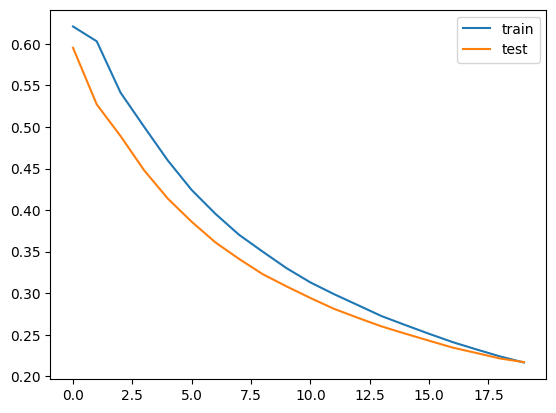

In [54]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

1/1 [==============================] - 15s 15s/step


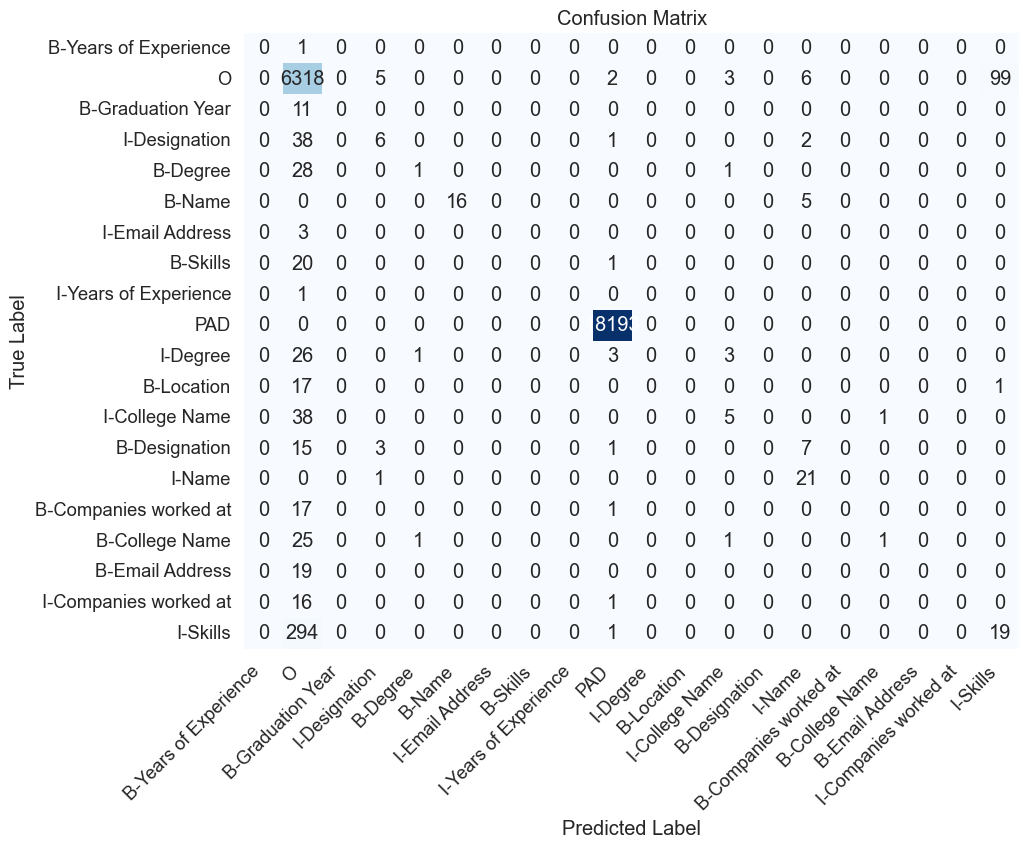

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Make predictions on the test set
predictions = model.predict(X_te)

# Convert predictions to POS tags
predicted_tags = np.argmax(predictions, axis=-1)
predicted_tags = [[idx2tag[tag] for tag in sample] for sample in predicted_tags]

# Flatten the predicted and true POS tag sequences
flatten_predicted = [tag for sample in predicted_tags for tag in sample]
flatten_true = [idx2tag[np.argmax(tag)] for sample in y_te for tag in sample]

# Get unique tags from the true and predicted sequences
unique_tags = list(set(flatten_true + flatten_predicted))

# Compute the confusion matrix
cm = confusion_matrix(flatten_true, flatten_predicted, labels=unique_tags)

# Create a DataFrame for the confusion matrix
cm_df = pd.DataFrame(cm, index=unique_tags, columns=unique_tags)

# Set up the plot
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm_df, annot=True, cmap="Blues", fmt="d", cbar=False)

# Customize the plot
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)

# Show the plot
plt.show()

In [56]:
from sklearn.metrics import classification_report
print("Classification Report:\n ", classification_report(flatten_predicted, flatten_true, labels=unique_tags))

C:\Users\punna\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\punna\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
                         precision    recall  f1-score   support

B-Years of Experience       0.00      0.00      0.00         0
                    O       0.98      0.92      0.95      6887
    B-Graduation Year       0.00      0.00      0.00         0
        I-Designation       0.13      0.40      0.19        15
             B-Degree       0.03      0.33      0.06         3
               B-Name       0.76      1.00      0.86        16
      I-Email Address       0.00      0.00      0.00         0
             B-Skills       0.00      0.00      0.00         0
I-Years of Experience       0.00      0.00      0.00         0
                  PAD       1.00      1.00      1.00     18204
             I-Degree       0.00      0.00      0.00         0
           B-Location       0.00      0.00      0.00         0
       I-College Name       0.11      0.38      0.18        13
        B-Designation       0.00      0.00      0.00         0
               I-Name       0

C:\Users\punna\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
